# Project Description: Twitter US Airline Sentiment

### Background: 
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

### Objective: 
Use ML techniques to classify positive, negative, and neutral tweets.

### Dataset:
https://www.kaggle.com/crowdflower/twitter-airline-sentiment

### Attributes:
- tweet_id
- airline_sentiment
- airline_sentiment_confidence
- negativereason
- negativereason_confidence
- airline
- airline_sentiment_gold
- name
- negativereason_gold
- retweet_count
- text
- tweet_coord
- tweet_created
- tweet_location
- user_timezone

## Import Necessary Libraries & Format Notebook

In [1]:
# Supress warnings
#import warnings
#warnings.filterwarnings('ignore')

#!pip install contractions
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import matplotlib.pyplot as plt
import seaborn as sns
import nltk                                             # Import Natural Language Tool-Kit.

# nltk.download('stopwords')                            # Download Stopwords.
# nltk.download('punkt')
# nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize                 # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [2]:
# Adjust display and formatting settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [30, 8]
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 500)           
pd.set_option('display.max_rows', 500)

## Exploratory Data Analysis

### Initial Data Observations

In [3]:
# Loading data into pandas dataframe
df = pd.read_csv("Tweets.csv")

In [4]:
# Print shape of dataset
df.shape

(14640, 15)

In [5]:
# Print first 5 rows of dataset
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.000,NaN,nan,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.349,NaN,0.000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.684,NaN,nan,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.000,Bad Flight,0.703,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.000,Can't Tell,1.000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Prepare Data: 
For purposes of sentiment analysis model building, we will drop all columns but 'text' and our target outcome column 'airline_sentiment'

In [6]:
# Remove all columns but 'airline_sentiment' and 'text' columns
df = df.loc[:, ['airline_sentiment', 'text']]

In [7]:
# Rename columns to more friendly names
df.rename(columns = {"airline_sentiment": "Sentiment", "text": "Text"}, inplace=True)

In [8]:
# Check the shape of dataset
df.shape

(14640, 2)

In [9]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  14640 non-null  object
 1   Text       14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [10]:
# Check for Null values
df.isnull().sum(axis=0)

Sentiment    0
Text         0
dtype: int64

In [11]:
# Print first 5 rows of dataset
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)
df.head(5)

,Sentiment,Text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


### Pre-Process Data

- Remove HTML tags
- Remove URL's
- Remove Twitter handles
- Replace contractions
- Remove numbers, punctuation, and special characters (keep hashtags as may be important)
- Remove short-words (2 characters or less)
- Convert to lowercase
- Tokenize words
- Remove stop words
- Lemmatize words 
- Combine tokenized words back to string

In [12]:
# Raw-text pre-process functions

# Remove HTML tags
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Remove URLs
def remove_urls(text):
    return re.sub(r'http\S+',' ', text)

# Remove Twitter handles (example: @user)
def remove_handles(text):
    return re.sub(r'@[\w]*',' ', text)

# Replace contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

# Remove numbers, punctuation, and special characters (keep hashtags #)
def remove_npsc(text):
    return re.sub(r'[^a-zA-Z#]', ' ', text)

# Remove short words (words 2 letters or less)
def remove_short_words(text):
    return (' '.join([w for w in text.split() if len(w)>2]))

# Convert all words to lower-case
def convert_to_lowercase(text):
    return text.lower()

# Perform raw-text pre-process functions
def normalize_raw_text(text):
    text = remove_html(text)
    text = remove_urls(text)
    text = remove_handles(text)
    text = replace_contractions(text)
    text = remove_npsc(text)
    text = remove_short_words(text)
    text = convert_to_lowercase(text)
    return text

In [13]:
# Pre-process raw-text into a new column called 'Clean_Text'
df['Clean_Text'] = df['Text'].apply(lambda x: normalize_raw_text(x))
df.head(10)

,Sentiment,Text,Clean_Text
0,neutral,@VirginAmerica What @dhepburn said.,what said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,plus you have added commercials the experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,did not today must mean need take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",really aggressive blast obnoxious entertainment your guests faces they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,and really big bad thing about
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,seriously would pay flight for seats that did not have this playing really the only bad thing about flying
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",yes nearly every time fly this ear worm will not away
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",really missed prime opportunity for men without hats parody there
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",well did not but now
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",was amazing and arrived hour early you are too good


In [14]:
# Tokenize pre-process functions

# Setup stop-words list
# Keep 'not' as it is important for sentiment analysis
stop_words = stopwords.words('english')
keep_words = ['not']
stop_words = list(set(stop_words) - set(keep_words)) 

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Tokenize Text String
def tokenize_string(text):
    return word_tokenize(text)

# Remove 'stop' words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

# Lemmatize words
def lemmatize_words(words):
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

# Process all functions and convert words back to text string
def normalize_token_text(text):
    words = tokenize_string(text)
    words = remove_stopwords(words)
    words = lemmatize_words(words)
    return ' '.join(words)

In [15]:
# Tokenize, remove stop words, lemmatize, and then combine back into a text string
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: normalize_token_text(x))
df.head(10)

,Sentiment,Text,Clean_Text
0,neutral,@VirginAmerica What @dhepburn said.,say
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,plus add commercials experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,not today must mean need take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",really aggressive blast obnoxious entertainment guests face little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,really big bad thing
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,seriously would pay flight seat not play really bad thing fly
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",yes nearly every time fly ear worm not away
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",really miss prime opportunity men without hat parody
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",well not
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",amaze arrive hour early good


In [18]:
# Add a Nmeric Sentiment to numeric 
df.loc[(df['Sentiment'] == 'negative'), 'Numeric_Sentiment'] = 0;
df.loc[(df['Sentiment'] == 'neutral'), 'Numeric_Sentiment'] = 1;
df.loc[(df['Sentiment'] == 'positive'), 'Numeric_Sentiment'] = 2;
df['Numeric_Sentiment'] = df['Numeric_Sentiment'].astype('int');
df.head(10)

,Sentiment,Text,Clean_Text,Numeric_Sentiment
0,neutral,@VirginAmerica What @dhepburn said.,say,1
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,plus add commercials experience tacky,2
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,not today must mean need take another trip,1
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",really aggressive blast obnoxious entertainment guests face little recourse,0
4,negative,@VirginAmerica and it's a really big bad thing about it,really big bad thing,0
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,seriously would pay flight seat not play really bad thing fly,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",yes nearly every time fly ear worm not away,2
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",really miss prime opportunity men without hat parody,1
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",well not,2
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",amaze arrive hour early good,2


### Build Random Forest Classifier Model - Count Vectorizer

In [22]:
# Vectorization (Convert text data to numbers).
vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features (limit processing)
data_features = vectorizer.fit_transform(df['Clean_Text'])     # Vectorize words
data_features = data_features.toarray()                        # Convert the data features to array.

In [23]:
# Check vectorized words
vectorizer.vocabulary_

{'say': 772,
 'plus': 672,
 'add': 12,
 'experience': 315,
 'not': 605,
 'today': 887,
 'must': 587,
 'mean': 547,
 'need': 590,
 'take': 863,
 'another': 46,
 'trip': 902,
 'really': 715,
 'entertainment': 291,
 'face': 322,
 'little': 512,
 'big': 105,
 'bad': 89,
 'thing': 873,
 'seriously': 788,
 'would': 987,
 'pay': 649,
 'flight': 354,
 'seat': 777,
 'play': 668,
 'fly': 364,
 'yes': 996,
 'every': 302,
 'time': 883,
 'away': 84,
 'miss': 573,
 'without': 977,
 'well': 967,
 'amaze': 38,
 'arrive': 65,
 'hour': 435,
 'early': 275,
 'good': 401,
 'know': 481,
 'second': 779,
 'lead': 491,
 'pretty': 686,
 'much': 584,
 'better': 103,
 'great': 402,
 'deal': 232,
 'already': 35,
 'think': 875,
 'even': 298,
 'go': 398,
 'yet': 998,
 'sky': 807,
 'travel': 898,
 'thank': 872,
 'sfo': 793,
 'pdx': 651,
 'schedule': 773,
 'still': 839,
 'mia': 559,
 'excite': 309,
 'first': 349,
 'cross': 214,
 'country': 206,
 'lax': 489,
 'mco': 544,
 'hear': 417,
 'nothing': 607,
 'things': 874,
 

In [24]:
# Shape of vectorized data
data_features.shape

(14640, 1000)

In [26]:
# Use Numeric Sentiment for our model
labels = df['Numeric_Sentiment']
labels = labels.astype('int')

In [27]:
# Split data into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=1)

In [28]:
# Using Random Forest to build model
forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(X_train, y_train)
print(np.mean(cross_val_score(forest, data_features, labels, cv=5)))

0.7387295081967213


In [29]:
# Predict the result for test data using the model built above.
result = forest.predict(X_test)

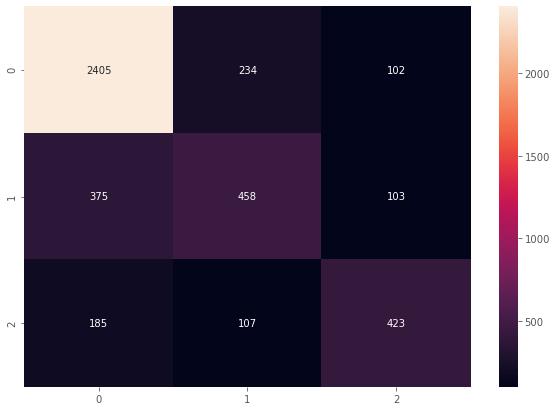

In [31]:
# Plot Confusion matrix
conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

### Build Random Forest Model - TF-IDF Vectorizer

In [32]:
# Using TfidfVectorizer to convert text data to numbers.
vectorizer = TfidfVectorizer(max_features=1000)
data_features = vectorizer.fit_transform(df['Clean_Text'])
data_features = data_features.toarray()

In [35]:
# Check vectorized words
vectorizer.vocabulary_

{'say': 772,
 'plus': 672,
 'add': 12,
 'experience': 315,
 'not': 605,
 'today': 887,
 'must': 587,
 'mean': 547,
 'need': 590,
 'take': 863,
 'another': 46,
 'trip': 902,
 'really': 715,
 'entertainment': 291,
 'face': 322,
 'little': 512,
 'big': 105,
 'bad': 89,
 'thing': 873,
 'seriously': 788,
 'would': 987,
 'pay': 649,
 'flight': 354,
 'seat': 777,
 'play': 668,
 'fly': 364,
 'yes': 996,
 'every': 302,
 'time': 883,
 'away': 84,
 'miss': 573,
 'without': 977,
 'well': 967,
 'amaze': 38,
 'arrive': 65,
 'hour': 435,
 'early': 275,
 'good': 401,
 'know': 481,
 'second': 779,
 'lead': 491,
 'pretty': 686,
 'much': 584,
 'better': 103,
 'great': 402,
 'deal': 232,
 'already': 35,
 'think': 875,
 'even': 298,
 'go': 398,
 'yet': 998,
 'sky': 807,
 'travel': 898,
 'thank': 872,
 'sfo': 793,
 'pdx': 651,
 'schedule': 773,
 'still': 839,
 'mia': 559,
 'excite': 309,
 'first': 349,
 'cross': 214,
 'country': 206,
 'lax': 489,
 'mco': 544,
 'hear': 417,
 'nothing': 607,
 'things': 874,
 

In [34]:
# Shape of vectorized data
data_features.shape

(14640, 1000)

In [36]:
# Split data into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=1)

In [37]:
# Using Random Forest to build model
forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(X_train, y_train)
print(np.mean(cross_val_score(forest, data_features, labels, cv=5)))

0.749863387978142


In [38]:
result = forest.predict(X_test)

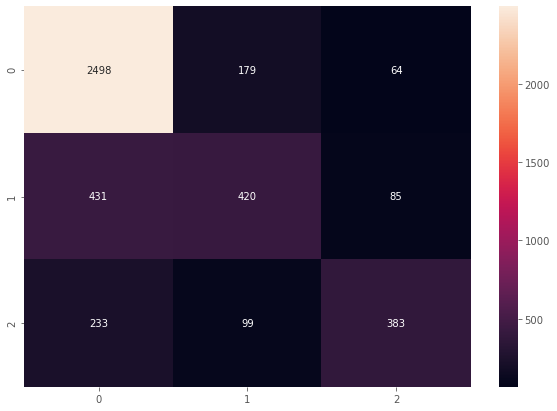

In [39]:
# Plot Confusion matrix
conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

## Summary: 

### Preprocessing of dataset:

Our dataset consisted mostly of unfiltered Twitter "tweets".  For NLP, we would like to reduce the words to only relevant words that can be vectorized into a matrix for use by various classification algorithms.

We started by pre-processing the text by removing non-relevant items (noise) such as HTML tags, URLs, and Twitter handles.  We chose to keep hashtag items as these can sometimes convey sentiment (in fact, there are some models that are based solely on hashtag analysis for sentiment analysis.)  We then replaced contractions with full words for better processing and removed numbers, punctuation, special characters and short words of 2 characters or less.  We then converted all of our text to lowercase to allow for better vectorization. 

We then "tokenized" the text strings into individual words for more specialized processing.  We used an NLTK library to remove "stop words" which are words that are deemed to be "common" terms and therefore not usually relevant for NLP.  We chose to keep the word "not" as it does convey some negative sentiment.  We chose to use Lemmatization for reducing the inflectional forms of each word and transforming those into a root meaning.  Once this processing was completed, we then transformed the tokenized words back to string text to be used by the vectorizors.

### Vectorization:

Vectorization is the process of converting text to numerical entries in a matrix form.  For our models, we chose two vectorization techniques for comparison.  Our first model uses Count Vectorization, whereby a document term matrix is generated where each cell is the count corresponding to the news title indicating the number of times a word appears in a document, also known as the term frequency.

Our second model uses a technique known as TF-IDF, which is similar to the count vectorization method, but differs in that each cell doesn’t indicate the term frequency, but the cell value represents a weighting that highlights the importance of that particular word to the document.

There are also additional vectorizations that we could have used such as N-gram, Word2Vec, Google Word2Vec, etc. that may have yielded better results.

### Modeling:

We chose to use a Random Forest Classifier model for this project.  There are many other models such as Naive Bayes, Logistic Regression, SVMs, and other deep learning models that could have been used.  We could also use any combination of hybrid models or combination of models to help achieve more accurate results. 

### Results: 

For this project, we created two models that were essentially the same but with different vectorizations.  With our chosen preprocessing, vectorizations, and classifier algorithms, we achieved cross-validation scores for:

- Count Vectorization: ~73.9% 
- TD-IDF Vectorization: ~74.9%

From our confusion matrix, there appeared to be a large number of negative comments.  Our models appeared to perform well when predicting correct negative sentiment text, but performance was lower when predicting neutral and positive sentiment texts.  

### Improvements:

There are many additional changes that we could make to try to improve our results.  We could experiment more on the preprocessing of the raw text itself before vectorization.  We could try additional vectorization techniques such as N-gram, Word2Vec, or Google Word2Vec, etc.  We could tweak our current models hyper-parameters and try different classifier models or hybrid models that were noted previously. 